# ПРОЕКТ: ОБУЧЕНИЕ С УЧИТЕЛЕМ: КАЧЕСТВО МОДЕЛИ

In [1]:
!pip install -U scikit-learn -q

**СОДЕРЖАНИЕ ПРОЕКТА**
1. [ОПИСАНИЕ ПРОЕКТА](#describ)

2. [ШАГ 1.ЗАГРУЗКА ДАННЫХ](#part_1)

3. [ШАГ 2.ПРЕДОБРАБОТКА ДАННЫХ](#part_2)
   
4. [ШАГ 3. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ (EDA)](#part_3)

5. [ШАГ 4. ОБЪЕДИНЕНИЕ ТАБЛИЦ](#part_4) 
    
5. [ШАГ 5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ](#part_5) 

6. [ШАГ 6. СОЗДАНИЕ ПАЙПЛАЙНА](#part_6) 
   
7. [ШАГ 7. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ](#part_7)

8. [ШАГ 8. СЕГМЕНТАЦИЯ ПОКУПАТЕЛЕЙ](#part_8)

8. [ШАГ 9. ВЫВОДЫ](#part_9)

## ОПИСАНИЕ ПРОЕКТА
<a id="describe"></a> 

Интернет-магазин продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина  показал снижение активности покупателей. Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Задачи проекта:

* Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
* Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

### Описание данных

Данные для работы находятся в нескольких таблицах.

    *таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.*

    *таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.*

    *таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.*

    *таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.*

**ЭТАПЫ РЕШЕНИЯ ЗАДАЧИ:**

* Разработка модели, которая предскажет вероятность снижения покупательской активности.
* Выделение сегмента покупателей, его анализ и выдвижение предложения об увеличении его покупательской активности. 

## ЗАГРУЗКА И ОПИСАНИЕ ДАННЫХ
<a id="part_1"></a> 

Загрузите данные. Проверьте, что данные в таблицах соответствуют описанию. 

In [2]:
! pip install phik -q

In [3]:
! pip install shap -q

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as st

from patsy import dmatrices

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    matthews_corrcoef, 
    f1_score, 
    cohen_kappa_score
)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import shap
import pandas as pd
import numpy as np
shap.initjs()

In [5]:
try:
    marketf = pd.read_csv('/datasets/market_file.csv')
except:
    marketf = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')    

In [6]:
marketf = marketf.rename(columns={'Покупательская активность':'активность', 'Тип сервиса':'сервис', 
                              'Разрешить сообщать': 'сообщать', 'Маркет_актив_6_мес': 'актив_6',
                             'Маркет_актив_тек_мес': 'актив_т', 'Длительность': 'дни', 
                            'Акционные_покупки': 'ак_покупки', 'Популярная_категория': 'поп_категория',
                            'Средний_просмотр_категорий_за_визит': 'кат_просмотр',
                            'Неоплаченные_продукты_штук_квартал': 'неоп_продукты', 'Ошибка_сервиса': 'ош_сервиса', 
                                 'Страниц_за_визит': 'стр_визит'}) 

In [7]:
display(marketf.head())

,id,активность,сервис,сообщать,актив_6,актив_т,дни,ак_покупки,поп_категория,кат_просмотр,неоп_продукты,ош_сервиса,стр_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
marketf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1300 non-null   int64  
 1   активность     1300 non-null   object 
 2   сервис         1300 non-null   object 
 3   сообщать       1300 non-null   object 
 4   актив_6        1300 non-null   float64
 5   актив_т        1300 non-null   int64  
 6   дни            1300 non-null   int64  
 7   ак_покупки     1300 non-null   float64
 8   поп_категория  1300 non-null   object 
 9   кат_просмотр   1300 non-null   int64  
 10  неоп_продукты  1300 non-null   int64  
 11  ош_сервиса     1300 non-null   int64  
 12  стр_визит      1300 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 132.2+ KB


Датафрейм marketf содержит 1300 ненулевых строк и 13 столбцов. Типы данных соответствуют содержимому. Наименования столбцов были переименованы для удобства.

In [9]:
try:
    marketm = pd.read_csv('/datasets/market_money.csv')
except:
    marketm = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')    

In [10]:
marketm = marketm.rename(columns={'Период':'период', 'Выручка':'выручка'})
display(marketm.head())

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [11]:
marketm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Датафрейм marketm содержит 3900 ненулевых строк и 3 столбца. Типы данных соответствуют содержимому. Наименования столбцов были переименованы для удобства.

In [12]:
try:
    markett = pd.read_csv('/datasets/market_time.csv')
except:
    markett = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')

In [13]:
markett = markett.rename(columns={'Период':'период', 'минут':'минуты'})
display(markett.head())

,id,период,минуты
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [14]:
markett.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минуты  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Датафрейм markett содержит 2600 ненулевых строк и 3 столбца. Типы данных соответствуют содержимому. Наименования столбцов были переименованы для удобства.

In [15]:
try:
    money = pd.read_csv('/datasets/money.csv', sep = ';')
except:
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';')
# money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

In [16]:
money = money.rename(columns={'Прибыль':'прибыль'})
display(money.head())

,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [17]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [18]:
money['прибыль'] = money['прибыль'].apply(lambda x: float(x.split()[0].replace(',','.')))
money['прибыль'] = money['прибыль'].astype('float') 

Датафрейм money содержит 1300 ненулевых строк и 2 столбца. Типы данных в столбце "прибыль" не соответствуют содержимому. Отделим целую часть числа от дробной вместо запятой - точкой и изменим тип данных на float. Наименования столбцов были переименованы для удобства.

## ПРЕДОБРАБОТКА ДАННЫХ
<a id="part_2"></a> 

Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

Посмотрим количество уникальных значений по нечисловым столбцам

In [19]:
list_marketf=['активность', 'сервис', 'сообщать', 'поп_категория']
for i in list_marketf:
    display(marketf[i].value_counts())

Прежний уровень    802
Снизилась          498
Name: активность, dtype: int64

стандарт     914
премиум      376
стандартт     10
Name: сервис, dtype: int64

да     962
нет    338
Name: сообщать, dtype: int64

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: поп_категория, dtype: int64

В столбце "сервис" указано три тарифа, но как видно, один из них имеет ошибку в написании, исправим это:

In [20]:
marketf['сервис'] = marketf['сервис'].str.replace('тт', 'т')

In [21]:
display(marketm['период'].value_counts())

текущий_месяц          1300
препредыдущий_месяц    1300
предыдущий_месяц       1300
Name: период, dtype: int64

In [22]:
display(markett['период'].value_counts())

предыдцщий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

In [23]:
markett['период'] = markett['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [24]:
marketf.duplicated().sum()

0

In [25]:
marketm.duplicated().sum()

0

In [26]:
markett.duplicated().sum()

0

Проверка количества уникальных значений и количества дубликатов, показала, что пропущенных значений в данных нет, дубликатов также нет. На первый взгляд, данные готовы к дальнейшему исследованию.

## ОБЪЕДИНЕНИЕ ТАБЛИЦ
<a id="part_4"></a> 

Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. Данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [27]:
marketm_pred_2 = marketm.query('период == "препредыдущий_месяц"')
marketm_pred_2=marketm_pred_2.rename(columns={'выручка':'выручка_пред_2'})
marketm_pred_2 = marketm_pred_2.drop('период', axis= 1)

In [28]:
marketm_pred_1 = marketm.query('период == "предыдущий_месяц"')
marketm_pred_1=marketm_pred_1.rename(columns={'выручка':'выручка_пред_1'})
marketm_pred_1 = marketm_pred_1.drop('период', axis= 1)

In [29]:
marketm_pred_0 = marketm.query('период == "текущий_месяц"')
marketm_pred_0=marketm_pred_0.rename(columns={'выручка':'выручка_пред_0'})
marketm_pred_0 = marketm_pred_0.drop('период', axis= 1)

In [30]:
markett_pred_0 = markett.query('период == "текущий_месяц"')
markett_pred_0=markett_pred_0.rename(columns={'минуты':'минуты_пред_0'})
markett_pred_0 = markett_pred_0.drop('период', axis= 1)

In [31]:
markett_pred_1 = markett.query('период == "предыдущий_месяц"')
markett_pred_1=markett_pred_1.rename(columns={'минуты':'минуты_пред_1'})
markett_pred_1 = markett_pred_1.drop('период', axis= 1)

In [32]:
market=pd.merge(marketf, marketm_pred_2)
market=pd.merge(market, marketm_pred_1)
market=pd.merge(market, marketm_pred_0)
market=pd.merge(market, markett_pred_1)
market=pd.merge(market, markett_pred_0)
market=pd.merge(market, money)
display(market.head(5))

,id,активность,сервис,сообщать,актив_6,актив_т,дни,ак_покупки,поп_категория,кат_просмотр,неоп_продукты,ош_сервиса,стр_визит,выручка_пред_2,выручка_пред_1,выручка_пред_0,минуты_пред_1,минуты_пред_0,прибыль
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14,0.98
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,4.16
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,3.13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,4.87
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,4.21


Данные объединены

In [33]:
marketm_2 = marketm.pivot_table(index = ['id'], columns = ['период'], values = ['выручка'])

In [34]:
# второй вариант
example_df = marketm_2.rename_axis(None)
example_df.columns = example_df.columns.get_level_values(1)
example_df = example_df.rename_axis(None, axis=1)
example_df.head(2)

,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6


In [35]:
# с переименованием тоже все работает.
market_20 = marketm_2.copy()

market_20.columns = ['выручка_пред_1', 'выручка_пред_2', 'выручка_пред_0']
market_20.head(2)

,выручка_пред_1,выручка_пред_2,выручка_пред_0
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6


## ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ
<a id="part_3"></a> 

Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.

In [36]:
market.duplicated().sum()

0

In [37]:
market_1 = market.query('выручка_пред_2 == 0 | выручка_пред_1 == 0 | выручка_пред_0 == 0')
market_1

,id,активность,сервис,сообщать,актив_6,актив_т,дни,ак_покупки,поп_категория,кат_просмотр,неоп_продукты,ош_сервиса,стр_визит,выручка_пред_2,выручка_пред_1,выручка_пред_0,минуты_пред_1,минуты_пред_0,прибыль
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14,0.98
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5,0.0,0.0,5986.3,12,6,4.66
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2,0.0,0.0,4735.0,13,11,5.08


Имеется три клиента, которые не делали покупки ежемесячно в последние три месяца. Их мы исключим из таблицы.

In [38]:
money_1 = money[~((money['id']==215348) | (money['id']==215357) | (money['id']==215359))]

In [39]:
market = market[~((market['выручка_пред_2'] == 0) | (market['выручка_пред_1'] == 0) | (market['выручка_пред_0'] == 0))]
market.shape

(1297, 19)

Рассчитаем числовые характеристики для непрерывных случайных величин

In [40]:
list_q = ['активность', 'сервис', 'сообщать', 'актив_6', 'актив_т', 'дни', 'ак_покупки', 
          'поп_категория', 'кат_просмотр', 'неоп_продукты', 'ош_сервиса', 'стр_визит', 
          'выручка_пред_2', 'выручка_пред_1', 'выручка_пред_0', 'минуты_пред_1', 'минуты_пред_0', 'прибыль']

market[list_q].describe().round(3)

,актив_6,актив_т,дни,ак_покупки,кат_просмотр,неоп_продукты,ош_сервиса,стр_визит,выручка_пред_2,выручка_пред_1,выручка_пред_0,минуты_пред_1,минуты_пред_0,прибыль
count,1297.000,1297.000,1297.000,1297.000,1297.000,1297.000,1297.000,1297.000,1297.000,1297.000,1297.000,1297.000,1297.000,1297.000
mean,4.254,4.009,602.994,0.321,3.268,2.841,4.184,8.187,4836.368,4948.340,5316.449,13.470,13.211,3.998
std,1.016,0.696,249.101,0.250,1.355,1.973,1.951,3.977,333.439,701.229,2942.469,3.936,4.220,1.011
min,0.900,3.000,121.000,0.110,1.000,0.000,0.000,1.000,4098.000,2890.000,2758.700,5.000,4.000,0.860
25%,3.700,4.000,410.000,0.170,2.000,1.000,3.000,5.000,4585.000,4498.500,4706.600,11.000,10.000,3.300
50%,4.200,4.000,607.000,0.240,3.000,3.000,4.000,8.000,4812.000,5005.500,5180.300,13.000,13.000,4.040
75%,4.900,4.000,806.000,0.300,4.000,4.000,6.000,11.000,5055.000,5409.000,5761.300,17.000,16.000,4.670
max,6.600,5.000,1079.000,0.990,6.000,10.000,9.000,20.000,5663.000,6869.500,106862.200,23.000,23.000,7.430


Числовые характеристики показывают, что среднее и медиана имеют сравнимые значения, то есть почти одинаковые, следовательно, можно предположить, что большлго количества выбросов в данных нет. Для более детального рассмотрения построим диаграммы "ящик с усами"

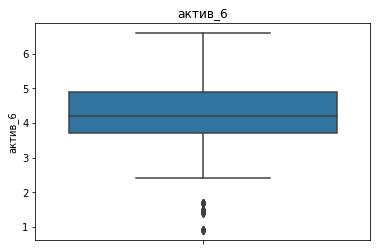

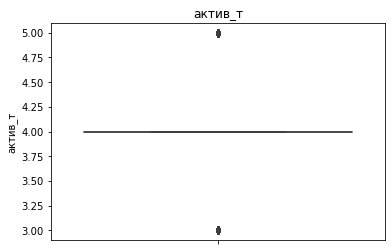

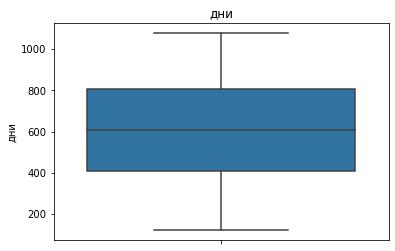

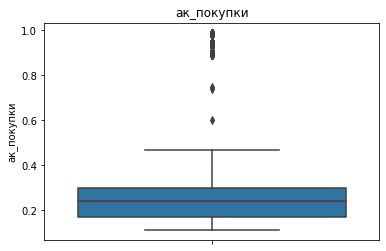

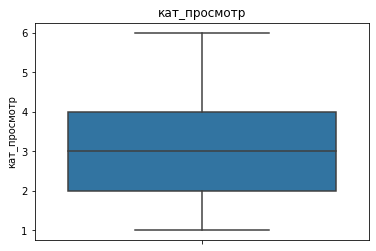

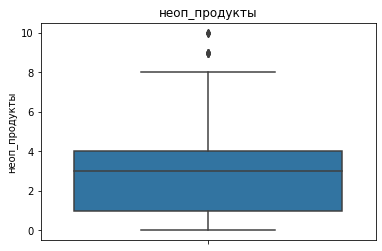

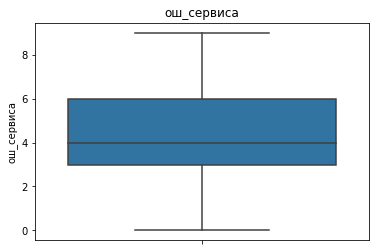

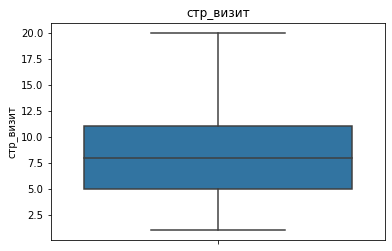

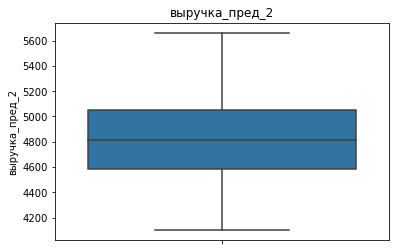

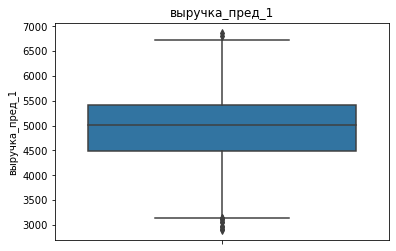

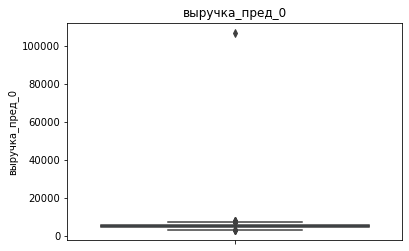

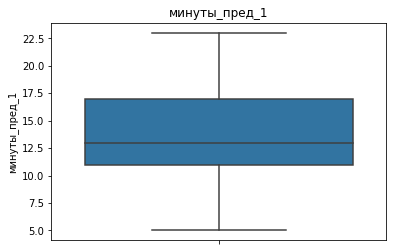

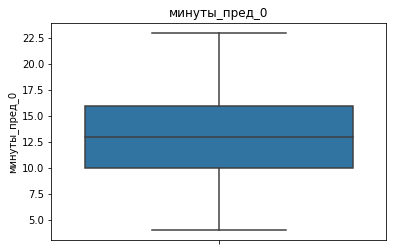

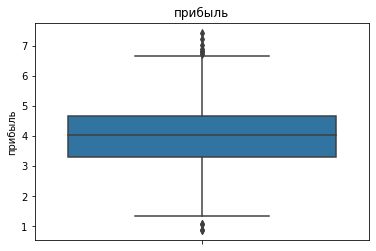

In [41]:
list_q1 = ['актив_6', 'актив_т', 'дни', 'ак_покупки', 
          'кат_просмотр', 'неоп_продукты', 'ош_сервиса', 'стр_визит', 
          'выручка_пред_2', 'выручка_пред_1', 'выручка_пред_0', 'минуты_пред_1', 'минуты_пред_0', 'прибыль']
for i in list_q1:
    sns.boxplot(y=i, data=market)
    plt.title(i)
    plt.ylabel(i)
    plt.show(); 

По даным диаграмм можно наблюдать выбросы по признакам: актив_6, ак_покупки, неоп_продукты, выручка_. Удалять их не будем, возможно, такие значения могут встречаться. А вот в столбце выручка_пред_0 явно имеется выброс, его будем удалять

In [42]:
market = market[~(market['выручка_пред_0'] > 20000)]
market.shape

(1296, 19)

Построим гистограммы 

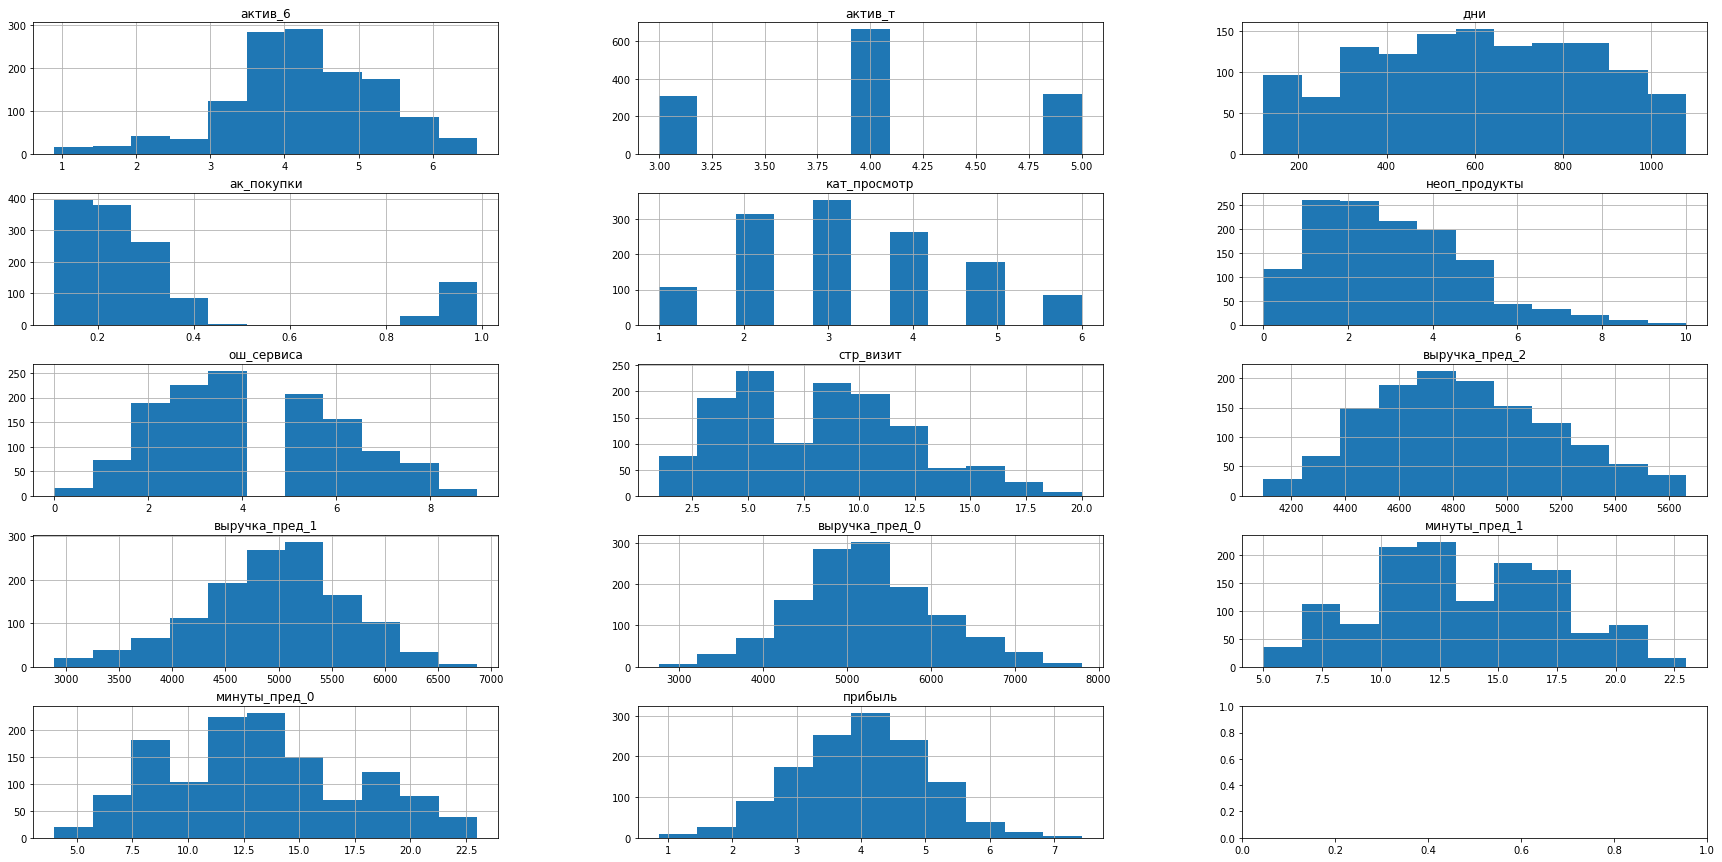

In [43]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(30,15))
axes_list = [item for sublist in axes for item in sublist]
for i in list_q1:
    ax = axes_list.pop(0)
    market.hist(i, figsize=(5, 3), ax=ax, bins=11)
plt.show;

Проверим гипотезу о нормальности распределения величин

    * H0 - распределение нормально
    * H1 - распределение ненормально

In [44]:
for i in list_q1:
    d = market[i]
    alpha = 0.05  
    results = st.shapiro(d)
    p_value = results[1]
    print(i)
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение ненормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

актив_6
p-значение:  3.785868103386991e-13
Отвергаем нулевую гипотезу: распределение ненормально
актив_т
p-значение:  8.104834990532471e-37
Отвергаем нулевую гипотезу: распределение ненормально
дни
p-значение:  5.746412121642418e-15
Отвергаем нулевую гипотезу: распределение ненормально
ак_покупки
p-значение:  4.203895392974451e-45
Отвергаем нулевую гипотезу: распределение ненормально
кат_просмотр
p-значение:  4.67610633319053e-24
Отвергаем нулевую гипотезу: распределение ненормально
неоп_продукты
p-значение:  1.163481088349155e-23
Отвергаем нулевую гипотезу: распределение ненормально
ош_сервиса
p-значение:  6.499693424121583e-17
Отвергаем нулевую гипотезу: распределение ненормально
стр_визит
p-значение:  1.544499696594457e-14
Отвергаем нулевую гипотезу: распределение ненормально
выручка_пред_2
p-значение:  1.154317530449589e-09
Отвергаем нулевую гипотезу: распределение ненормально
выручка_пред_1
p-значение:  1.308405046529515e-07
Отвергаем нулевую гипотезу: распределение ненормально
вы

Данные, кроме прибыли, в датафрейме распределены ненормально

Построим гистограммы распределения категориальных признаков

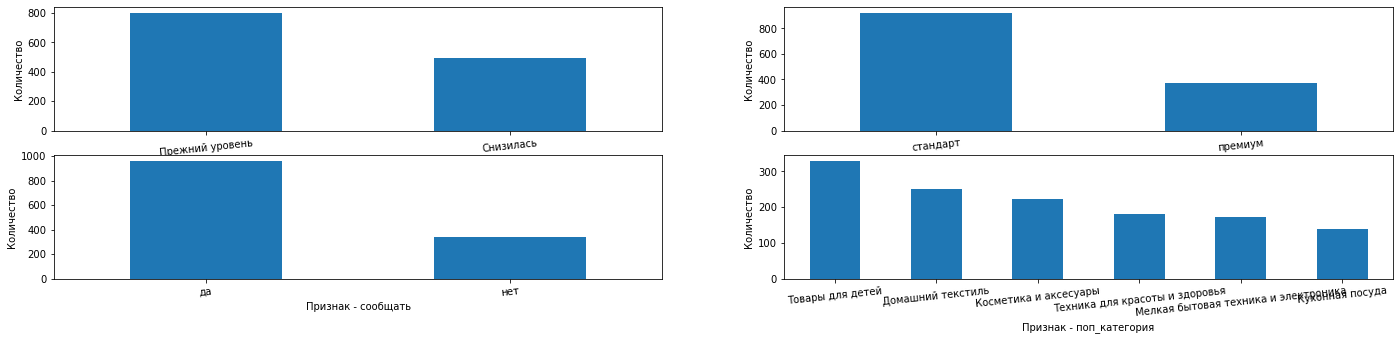

In [45]:
list_cat = ['активность', 'сервис', 'сообщать', 'поп_категория']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,5))
axes_list = [item for sublist in axes for item in sublist]
for i in list_cat:
    ax = axes_list.pop(0)
    market[i].value_counts().plot(kind='bar', xlabel='Признак - '+str(i), ylabel='Количество', rot=6, ax=ax)
plt.show;

На графиках видно, что что активность снизилась у 550 человек, примиум сервис используют 400, а стандарт 900 человек, 400 человек не дают разрешение на сообщения, а 900 дают, товары для детей пользуются большим интересом, чем товары других категорий.

In [46]:
market_2 = market.drop('id', axis = 1)

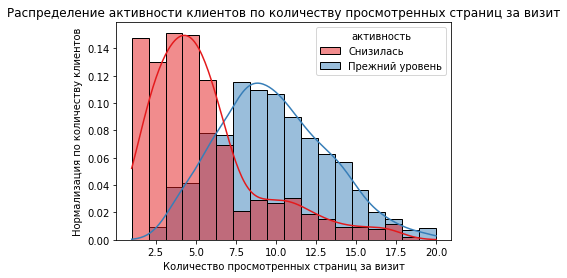

In [47]:
sns.histplot(data=market_2, hue='активность', x='стр_визит', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по количеству просмотренных страниц за визит')    
plt.xlabel('Количество просмотренных страниц за визит')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

Уровень активности снижается у клиентов, которые просматривают от 0 до 6 страниц за визит

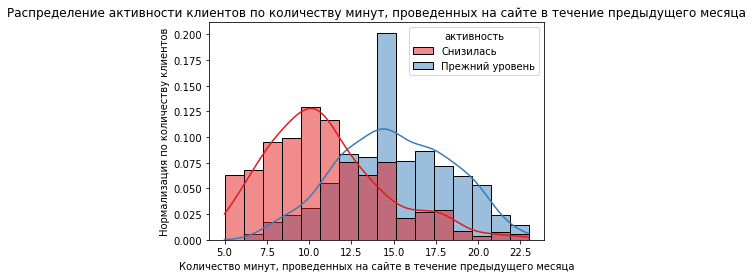

In [48]:
sns.histplot(data=market_2, hue='активность', x='минуты_пред_1', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по количеству минут, проведенных на сайте в течение предыдущего месяца')    
plt.xlabel('Количество минут, проведенных на сайте в течение предыдущего месяца')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

Уровень активности снижается, если клиент проводит на сайте за предыдущий месяц от 5 до 11 минут

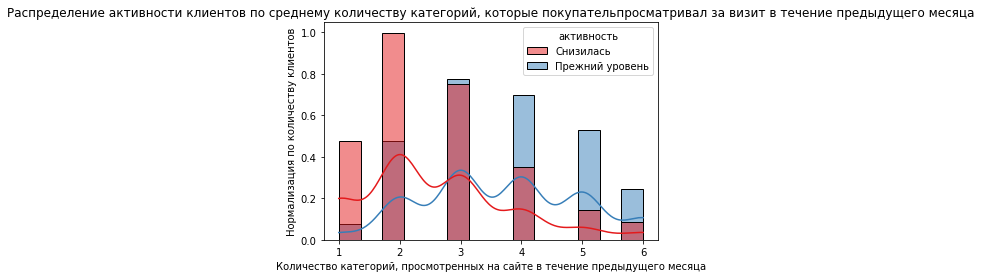

In [49]:
sns.histplot(data=market_2, hue='активность', x='кат_просмотр', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по среднему количеству категорий, которые покупатель\
просматривал за визит в течение предыдущего месяца')    
plt.xlabel('Количество категорий, просмотренных на сайте в течение предыдущего месяца')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

Уровень активности снижается, если клиент в среднем просматривал за визит в течение последнего месяца 1-2 категории 

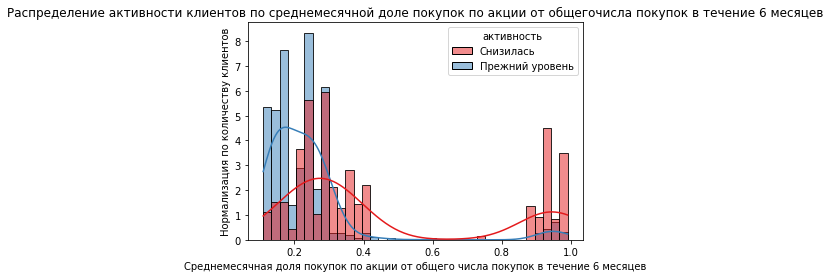

In [50]:
sns.histplot(data=market_2, hue='активность', x='ак_покупки', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по среднемесячной доле покупок по акции от общего\
числа покупок в течение 6 месяцев')    
plt.xlabel('Среднемесячная доля покупок по акции от общего числа покупок в течение 6 месяцев')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

Активность снижается, если среднемесячная доля покупок по акции достигает от 0.3 до 1

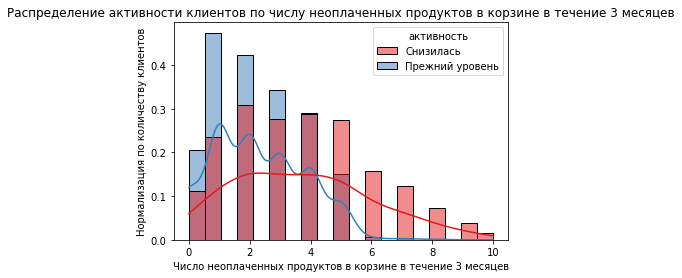

In [51]:
sns.histplot(data=market_2, hue='активность', x='неоп_продукты', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по числу неоплаченных продуктов в корзине в течение 3 месяцев')    
plt.xlabel('Число неоплаченных продуктов в корзине в течение 3 месяцев')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

Активность снижается, если число неоплаченных продуктов в корзине от 4 и выше

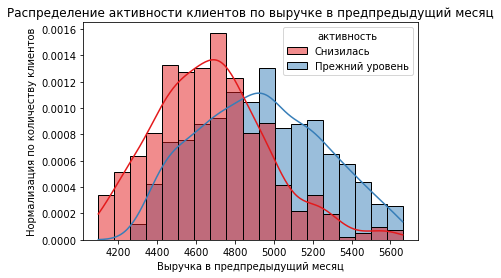

In [52]:
sns.histplot(data=market_2, hue='активность', x='выручка_пред_2', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по выручке в предпредыдущий месяц')    
plt.xlabel('Выручка в предпредыдущий месяц')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

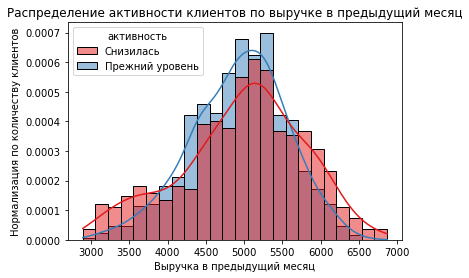

In [53]:
sns.histplot(data=market_2, hue='активность', x='выручка_пред_1', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по выручке в предыдущий месяц')    
plt.xlabel('Выручка в предыдущий месяц')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

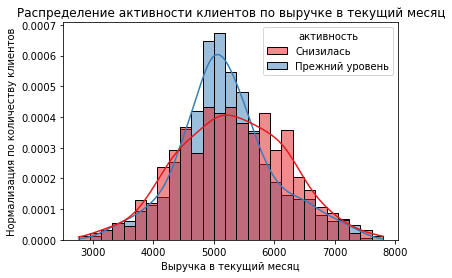

In [54]:
sns.histplot(data=market_2, hue='активность', x='выручка_пред_0', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по выручке в текущий месяц')    
plt.xlabel('Выручка в текущий месяц')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

Активность снизилась у клиентов, выручка от которых в последние два месяца была выше, чем от тех, у кого активность осталась на прежнем уровне

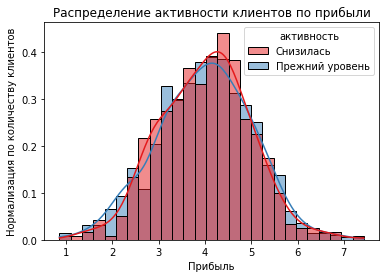

In [55]:
sns.histplot(data=market_2, hue='активность', x='прибыль', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по прибыли')    
plt.xlabel('Прибыль')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

Активность снизилась у клиентов, прибыль от которых от 4 до 4.8 

* Уровень активности снижается у клиентов, которые просматривают от 0 до 6 страниц за визит ('стр_визит')
* Уровень активности снижается, если клиент проводит на сайте за предыдущий месяц от 5 до 11 минут ('минуты_пред_1')
* Уровень активности снижается, если клиент в среднем просматривал за визит в течение последнего месяца 1-2 категории ('кат_просмотр')
* Активность снижается, если среднемесячная доля покупок по акции достигает от 0.3 до 1 ('ак_покупки')
* Активность снижается, если число неоплаченных продуктов в корзине от 4 и выше ('неоп_продукты')
* Активность снизилась у клиентов, выручка от которых в последние два месяца была выше, чем от тех, у кого активность осталась на прежнем уровне
* Активность снизилась у клиентов, прибыль от которых от 4 до 4.8 

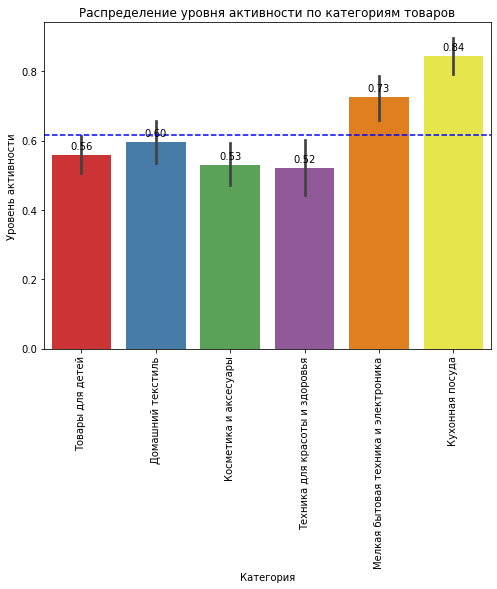

In [56]:
market_2.loc[market_2['активность'] == 'Снизилась', 'активность_1'] = 0
market_2.loc[market_2['активность'] == 'Прежний уровень', 'активность_1'] = 1
plt.figure(figsize=(8, 6))

a=sns.barplot(data=market_2, x='поп_категория', y='активность_1', palette = 'Set1')
a.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.axhline(y=.615, color='blue', linestyle='--')

plt.title('Распределение уровня активности по категориям товаров')   
plt.xlabel('Категория')
plt.ylabel('Уровень активности')
for p in a.patches:
    a.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show;

Уровень активности ниже среднего уровня активности в целом по группам товаров: товары для детей (0.56), домашний текстиль (0.6), косметика и аксессуары (0.53), техника для красоты и здоровья (0.52) 

In [57]:
market_5 = market_2.query('поп_категория=="Косметика и аксесуары" & прибыль>=4 & прибыль<=4.8')

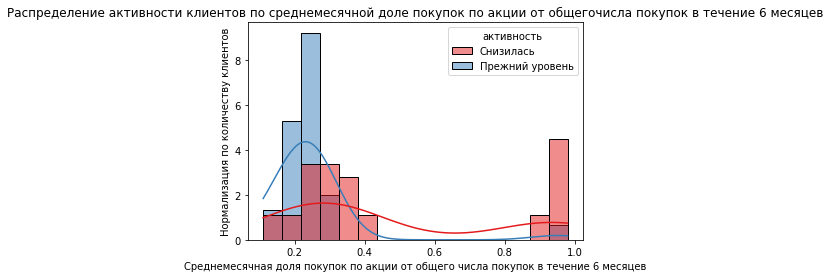

In [58]:
# Косметика и аксесуары
sns.histplot(data=market_5, hue='активность', x='ак_покупки', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по среднемесячной доле покупок по акции от общего\
числа покупок в течение 6 месяцев')    
plt.xlabel('Среднемесячная доля покупок по акции от общего числа покупок в течение 6 месяцев')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

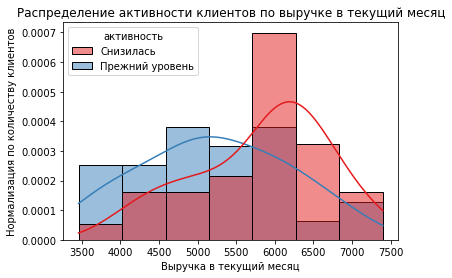

In [59]:
#Косметика и аксесуары
sns.histplot(data=market_5, hue='активность', x='выручка_пред_0', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по выручке в текущий месяц')    
plt.xlabel('Выручка в текущий месяц')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

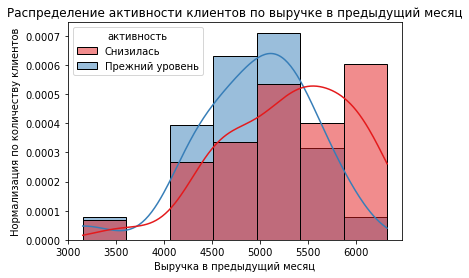

In [60]:
#Косметика и аксесуары
sns.histplot(data=market_5, hue='активность', x='выручка_пред_1', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по выручке в предыдущий месяц')    
plt.xlabel('Выручка в предыдущий месяц')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

In [61]:
market_6 = market_2.query('поп_категория=="Товары для детей" & прибыль>=4 & прибыль<=4.8')

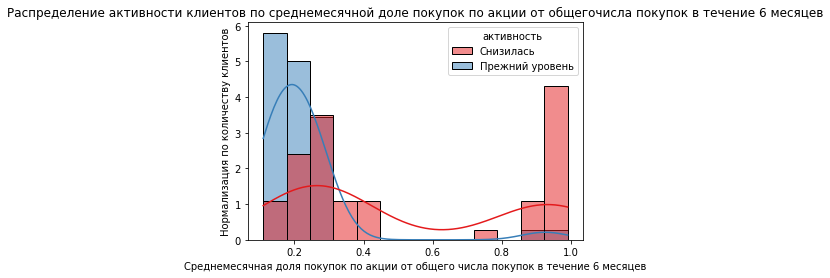

In [62]:
sns.histplot(data=market_6, hue='активность', x='ак_покупки', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по среднемесячной доле покупок по акции от общего\
числа покупок в течение 6 месяцев')    
plt.xlabel('Среднемесячная доля покупок по акции от общего числа покупок в течение 6 месяцев')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

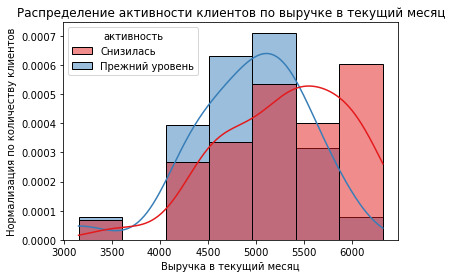

In [63]:
sns.histplot(data=market_5, hue='активность', x='выручка_пред_1', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по выручке в текущий месяц')    
plt.xlabel('Выручка в текущий месяц')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

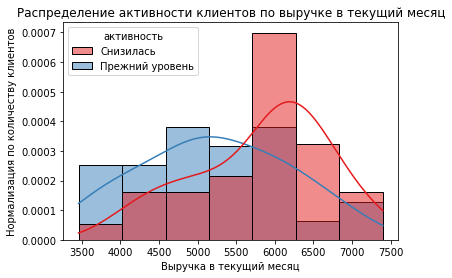

In [64]:
sns.histplot(data=market_5, hue='активность', x='выручка_пред_0', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по выручке в текущий месяц')    
plt.xlabel('Выручка в текущий месяц')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

In [65]:
market_7 = market_2.query('поп_категория=="Кухонная посуда" & прибыль>=4 & прибыль<=4.8')

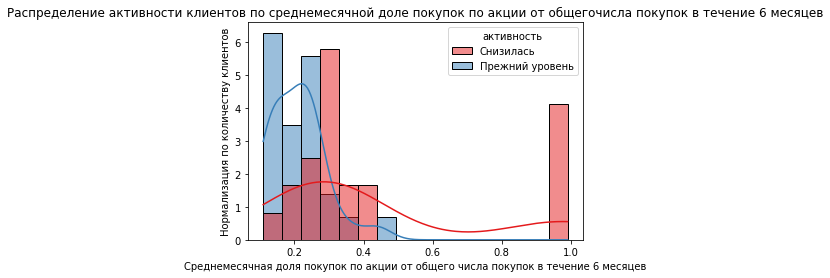

In [66]:
sns.histplot(data=market_7, hue='активность', x='ак_покупки', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по среднемесячной доле покупок по акции от общего\
числа покупок в течение 6 месяцев')    
plt.xlabel('Среднемесячная доля покупок по акции от общего числа покупок в течение 6 месяцев')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

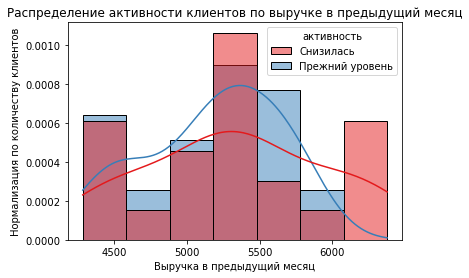

In [67]:
sns.histplot(data=market_7, hue='активность', x='выручка_пред_1', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по выручке в предыдущий месяц')    
plt.xlabel('Выручка в предыдущий месяц')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

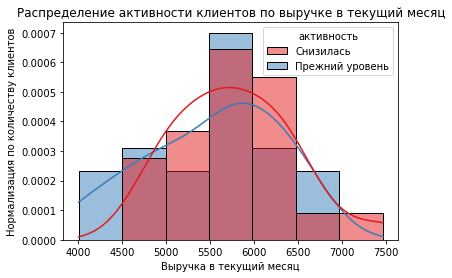

In [68]:
sns.histplot(data=market_7, hue='активность', x='выручка_пред_0', stat='density', 
                 common_norm=False, palette = 'Set1', kde=True)
plt.title('Распределение активности клиентов по выручке в текущий месяц')    
plt.xlabel('Выручка в текущий месяц')
plt.ylabel('Нормализация по количеству клиентов')
plt.show;

In [69]:
t = round(len(market_2.query('стр_визит>=0 & стр_визит<=6 & активность=="Снизилась"')) / len(market_2.query('стр_визит>=0 & стр_визит<=6')),3)*100
print('снижение активности по признаку "стр_визит" составил: '+ str(t) + ' процента')

снижение активности по признаку "стр_визит" составил: 71.89999999999999 процента


In [70]:
len(market_2.query('стр_визит>=0 & стр_визит<=6'))

505

In [71]:
t = round(len(market_2.query('минуты_пред_1>=5 & минуты_пред_1<=11 & активность=="Снизилась"')) / len(market_2.query('минуты_пред_1>=5 & минуты_пред_1<=11')),3)*100
print('снижение активности по признаку "минуты_пред_1" составил: '+ str(t) + ' процента')

снижение активности по признаку "минуты_пред_1" составил: 72.39999999999999 процента


In [72]:
len(market_2.query('минуты_пред_1>=5 & минуты_пред_1<=11'))

439

In [73]:
t = round(len(market_2.query('кат_просмотр>=1 & кат_просмотр<=2 & активность=="Снизилась"')) / len(market_2.query('кат_просмотр>=1 & кат_просмотр<=2')),3)*100
print('снижение активности по признаку "кат_просмотр" составил: '+ str(t) + ' процента')

снижение активности по признаку "кат_просмотр" составил: 62.2 процента


In [74]:
len(market_2.query('кат_просмотр>=1 & кат_просмотр<=2'))

418

In [75]:
len(market_2.query('ак_покупки>=0.3 & ак_покупки<=1'))

391

In [76]:
t = round(len(market_2.query('ак_покупки>=0.3 & ак_покупки<=1 & активность=="Снизилась"')) / len(market_2.query('ак_покупки>=0.3 & ак_покупки<=1')),3)*100
print('снижение активности по признаку "ак_покупки" составил: '+ str(t) + ' процента')

снижение активности по признаку "ак_покупки" составил: 71.89999999999999 процента


In [77]:
t = round(len(market_2.query('неоп_продукты>=4 & активность=="Снизилась"')) / len(market_2.query('неоп_продукты>=4')),3)*100
print('снижение активности по признаку "неоп_продукты" составил: '+ str(t) + ' процента')

снижение активности по признаку "неоп_продукты" составил: 56.8 процента


In [78]:
len(market_2.query('неоп_продукты>=4'))

444

In [79]:
t = round(len(market_2.query('прибыль>=4 & прибыль<=4.8 & активность=="Снизилась"')) / len(market_2.query('прибыль>=4 & прибыль<=4.8')),3)*100
print('снижение активности по признаку "прибыль" составил: '+ str(t) + ' процента')

снижение активности по признаку "прибыль" составил: 40.699999999999996 процента


In [80]:
len(market_2.query('прибыль>=4 & прибыль<=4.8'))

396

Как правило, активность снижается после проведения акций, когда клиенты в предпоследний и текущий месяц потратили много денег

## КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
<a id="part_5"></a> 

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

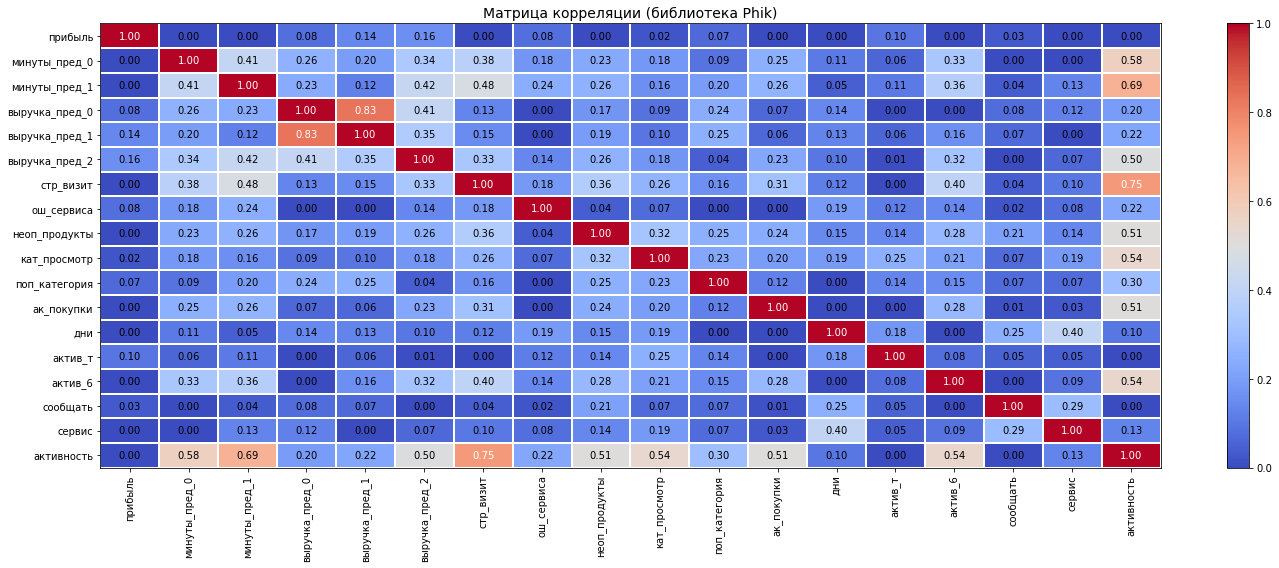

In [81]:
market_2 = market.drop('id', axis = 1)
phik_corr = market_2.phik_matrix(interval_cols =['актив_6', 'актив_т', 'дни', 'ак_покупки', 
          'кат_просмотр', 'неоп_продукты', 'ош_сервиса', 'стр_визит', 
          'выручка_пред_2', 'выручка_пред_1', 'выручка_пред_0', 'минуты_пред_1', 'минуты_пред_0', 'прибыль'])
plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns, 
                        y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map="coolwarm",
                        title=r"Матрица корреляции (библиотека Phik)", 
                        fontsize_factor=1, 
                        figsize=(20, 8))
plt.tight_layout()

По матрице видно, согласно шкале Чеддока, что:

        имеется высокая взаимосвязь между:
        
        * "выручка_пред_1" и "выручка_пред_2" (0.73)
        * "выручка_пред_2" и "ак_покупки" (0.75)
    
        заметная взаимосвязь:
        
        * "выручка_пред_1" и "ак_покупки" (0.64)
        * "минуты_пред_1" и "активность" (0.68)
        * "минуты_пред_0" и "активность" (0.58)   

Исследуем мультиколлинеарность с помощью коэффициента инфляции дисперсии (VIF) , который измеряет корреляцию и силу корреляции между независимыми переменными

In [82]:
def vif(i):
    y, X = dmatrices(i, data=market_2, return_type='dataframe')
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] =vif['VIF'].round(3)
    vif['variable'] = X.columns
    display(vif)
print('прибыль ~ активность+сервис+сообщать+актив_6+актив_т+дни+ак_покупки+поп_категория+\
        кат_просмотр+неоп_продукты+ош_сервиса+стр_визит+выручка_пред_2+выручка_пред_1+выручка_пред_0+минуты_пред_1+\
        минуты_пред_0')
v_1 = vif('прибыль ~ активность+сервис+сообщать+актив_6+актив_т+дни+ак_покупки+поп_категория+\
          кат_просмотр+неоп_продукты+ош_сервиса+стр_визит+выручка_пред_2+выручка_пред_1+выручка_пред_0+\
          минуты_пред_1+минуты_пред_0')

прибыль ~ активность+сервис+сообщать+актив_6+актив_т+дни+ак_покупки+поп_категория+        кат_просмотр+неоп_продукты+ош_сервиса+стр_визит+выручка_пред_2+выручка_пред_1+выручка_пред_0+минуты_пред_1+        минуты_пред_0


,VIF,variable
0,407.551,Intercept
1,2.179,активность[T.Снизилась]
2,1.184,сервис[T.стандарт]
3,1.113,сообщать[T.нет]
4,1.706,поп_категория[T.Косметика и аксесуары]
5,1.488,поп_категория[T.Кухонная посуда]
6,1.576,поп_категория[T.Мелкая бытовая техника и элект...
7,1.599,поп_категория[T.Техника для красоты и здоровья]
8,1.852,поп_категория[T.Товары для детей]
9,1.260,актив_6


**Значение VIF начинается с 1 и не имеет верхнего предела. Общее эмпирическое правило для интерпретации VIF выглядит следующим образом:**
* Значение 1 указывает на отсутствие корреляции между данной независимой переменной и любыми другими независимыми переменными в модели.
* Значение от 1 до 5 указывает на умеренную корреляцию между данной объясняющей переменной и другими независимыми переменными в модели, но часто она недостаточно серьезна, чтобы требовать внимания.
* Значение больше 5 указывает на потенциально сильную корреляцию между данной независимой переменной и другими независимыми переменными в модели. В этом случае оценки коэффициентов и p-значения в выходных данных регрессии, вероятно, ненадежны.

**В нашем случае все коэффициенты находятся в пределах от 1 до 5, что говорит об умеренной корреляции, а следовательно можно полагать, что даже в случае присутствия некоторой мультиколлинеарности, модель покажет правдивые результаты.**

## СОЗДАНИЕ ПАЙПЛАЙНА
<a id="part_6"></a> 

Примените все изученные модели. Для этого используйте пайплайны.
* Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
* Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.
* Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий: 
        * использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно; 
        * использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [83]:
# market_2 = market_2[~((market_2['выручка_пред_2'] == 0) & (market_2['выручка_пред_1'] == 0))]

In [84]:
# 
market_2['выручка_пред_0'].max()

7799.4

In [85]:
RANDOM_STATE = 50
TEST_SIZE = 0.25

X = market_2.drop(['активность', 'прибыль'], axis=1)
y = market_2['активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['сервис', 'сообщать']
ord_columns = ['поп_категория']
num_columns = ['актив_6', 'актив_т', 'дни', 'ак_покупки', 'кат_просмотр', 'неоп_продукты', 'ош_сервиса', 'стр_визит',\
              'выручка_пред_2', 'выручка_пред_1', 'выручка_пред_0', 'минуты_пред_1', 'минуты_пред_0']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', sparse=False))])
ord_pipe = Pipeline([('ord',  OrdinalEncoder(categories=[['Товары для детей', 'Домашний текстиль', 
                  'Косметика и аксесуары', 'Техника для красоты и здоровья',
                  'Мелкая бытовая техника и электроника', 'Кухонная посуда'],], handle_unknown='use_encoded_value',
    unknown_value=np.nan))])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)], remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight= 'balanced'))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
           random_state=RANDOM_STATE, 
           solver='liblinear', 
            penalty='l1'
       )],
        'models__C': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear','rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

y_train = y_train.apply(lambda x: 1 if x == 'Снизилась' else 0)
y_test = y_test.apply(lambda x: 1 if x == 'Снизилась' else 0)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)


# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['сервис', 'сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['Товары '
                                                                                               'для '
                                                                                               'детей',
                                 

In [86]:
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
6,1,"LogisticRegression(penalty='l1', random_state=...",0.900736,"{'preprocessor__num': 'passthrough', 'models__..."
5,2,DecisionTreeClassifier(random_state=50),0.853842,"{'preprocessor__num': 'passthrough', 'models__..."
9,3,DecisionTreeClassifier(random_state=50),0.839100,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,4,DecisionTreeClassifier(random_state=50),0.818928,"{'preprocessor__num': StandardScaler(), 'model..."
8,5,DecisionTreeClassifier(random_state=50),0.806285,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,6,DecisionTreeClassifier(random_state=50),0.804644,"{'preprocessor__num': StandardScaler(), 'model..."
2,7,DecisionTreeClassifier(random_state=50),0.797598,"{'preprocessor__num': StandardScaler(), 'model..."
0,8,DecisionTreeClassifier(random_state=50),0.789448,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,9,KNeighborsClassifier(),0.788039,"{'preprocessor__num': 'passthrough', 'models__..."
7,10,DecisionTreeClassifier(random_state=50),0.777432,"{'preprocessor__num': StandardScaler(), 'model..."


Метриками качества моделей при решении задачи классификации являются F1-мера, precision, recall и другие. Все эти инструменты оценивают работу модели по её результатам и напрямую связаны с порогом вероятности, по которому модель присваивает метку класса. Поэтому все эти метрики изменяются вместе с результатами классификации. Метрика ROC-AUC - показатель, который оценивает работу модели более обобщённо, независимо от того, какой порог классификации выбираем.

In [87]:
randomized_search.best_estimator_.named_steps['models']

LogisticRegression(C=2, penalty='l1', random_state=50, solver='liblinear')

In [88]:
market_all = X_test.copy()
market_all['y_test'] = y_test
market_all.reset_index(inplace=True) 

market_all['y_test_pred1'] = randomized_search.predict_proba(X_test)[:, 1]
market_all = market_all.merge(money_1, left_index=True, right_index=True)
display(market_all.head(5))

,index,сервис,сообщать,актив_6,актив_т,дни,ак_покупки,поп_категория,кат_просмотр,неоп_продукты,...,стр_визит,выручка_пред_2,выручка_пред_1,выручка_пред_0,минуты_пред_1,минуты_пред_0,y_test,y_test_pred1,id,прибыль
1,809,стандарт,да,4.0,3,432,0.16,Косметика и аксесуары,4,1,...,13,4685.0,5646.5,6609.8,17,22,0,0.014590,215349,4.16
2,148,премиум,да,4.0,4,684,0.40,Техника для красоты и здоровья,1,6,...,4,4896.0,5020.0,5237.1,11,11,1,0.946645,215350,3.13
3,192,премиум,да,1.4,5,355,0.33,Мелкая бытовая техника и электроника,1,1,...,5,4826.0,5277.5,6118.6,9,10,1,0.907173,215351,4.87
4,786,премиум,да,3.3,5,786,0.16,Косметика и аксесуары,4,0,...,11,4590.0,4926.0,5347.2,8,19,0,0.144479,215352,4.21
5,196,стандарт,да,2.4,4,1025,0.40,Кухонная посуда,3,2,...,6,4314.0,4732.5,4954.8,9,12,1,0.833945,215353,3.95


## АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
<a id="part_7"></a> 

* Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
* Сделайте выводы о значимости признаков:
        какие признаки мало значимы для модели;
        какие признаки сильнее всего влияют на целевой признак;
        как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,сервис_стандарт,сообщать_нет,актив_6,актив_т,дни,ак_покупки,кат_просмотр,неоп_продукты,ош_сервиса,стр_визит,выручка_пред_2,выручка_пред_1,выручка_пред_0,минуты_пред_1,минуты_пред_0,поп_категория
0,0.0,0.0,0.127844,-0.041113,0.863302,1.653258,0.559642,0.567458,-1.102352,-0.779670,-1.086979,0.360149,-0.326980,-0.369613,-0.756022,0.0
1,1.0,1.0,0.626900,-1.468316,-0.238817,-0.727838,1.300748,-0.431762,-1.611130,-0.779670,-0.040044,0.702604,-0.223430,-1.372443,-0.044644,1.0
2,1.0,0.0,-1.069888,1.386091,1.166384,2.590083,1.300748,-1.430981,0.932759,-1.029206,-0.137640,1.695938,1.628061,-0.620320,-0.044644,0.0
3,1.0,1.0,0.826522,-1.468316,1.827655,2.394911,-0.181464,-0.431762,-0.593574,-1.528277,-0.726171,1.198916,0.747768,-1.372443,-0.518896,0.0
4,1.0,0.0,-0.970077,-0.041113,0.638942,-0.259426,0.559642,-0.931372,-1.611130,-1.029206,0.841274,-0.316963,0.170370,-0.871028,-0.756022,1.0


Метрика ROC-AUC на тестовой выборке: 0.9105286575253813


,test,pred_1
0,0,0.024199
1,0,0.015915
2,1,0.947529
3,1,0.912152
4,0,0.149209
...,...,...
319,0,0.213175
320,0,0.092850
321,0,0.132019
322,1,0.931527


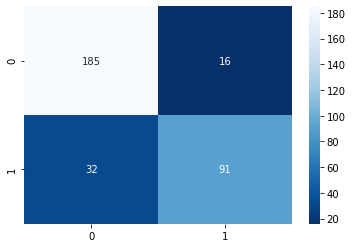

acc (отношение верных ответов к общему количеству ответов) =  0.85
recall (полнота, смогла ли модель классификации присвоить класс 1 всем объектам этого класса) =  0.74
precisions (точность, с которой модель присваивает объектам класс 1) =  0.85
Коэффициент Мэттьюса: 0.681
F1-мера: 0.791
Каппа Коэна: 0.677


In [89]:
RANDOM_STATE = 50
TEST_SIZE = 0.25

X = market_2.drop(['активность', 'прибыль'], axis=1)
y = market_2['активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

# создаём списки с названиями признаков
ohe_columns = ['сервис', 'сообщать']
ord_columns = ['поп_категория']
num_columns = ['актив_6', 'актив_т', 'дни', 'ак_покупки', 'кат_просмотр', 'неоп_продукты', 'ош_сервиса', 'стр_визит',\
              'выручка_пред_2', 'выручка_пред_1', 'выручка_пред_0', 'минуты_пред_1', 'минуты_пред_0']


## Нормализуем категориальные признаки с помощью One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])
X_ohe = encoder.transform(X[ohe_columns])
encoder_col_names = encoder.get_feature_names_out()

# Масштабируем количественные признаки с помощью StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
X_scaled = scaler.transform(X[num_columns])

# Создаем экземпляр класса OrdinalEncoder д
ordered_encoder = OrdinalEncoder(categories=[['Товары для детей', 'Домашний текстиль', 
                  'Косметика и аксесуары', 'Техника для красоты и здоровья',
                  'Мелкая бытовая техника и электроника', 'Кухонная посуда'],], handle_unknown='use_encoded_value',
    unknown_value=np.nan)

# обучаем OrdinalEncoder на выбранных признаках из тренировочной выборки
# преобразовываем тренировочную выборку
X_train_ord = ordered_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ordered_encoder.transform(X_test[ord_columns])
X_ord = ordered_encoder.transform(X[ord_columns])

# Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных. 
# Для данных OHE названия столбцов берем из переменной encoder_col_names
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_columns)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_columns)

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_columns)
X_ord = pd.DataFrame(X_ord, columns=ord_columns)

# Объединяем все преобразованные данные в тренировочный и тестовый датафреймы. 
# Сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
X_train = pd.concat([X_train_ohe, X_train_scaled, X_train_ord], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled, X_test_ord], axis=1)
X_2 = pd.concat([X_ohe, X_scaled, X_ord], axis=1)    
   
# Инициализируем модель логистической регресси и обучим модель на тренировочных данных. 
clf = LogisticRegression(C=5, penalty='l1', random_state=50,
                                    solver='liblinear')
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict_proba(X_test)
y_test_pred = y_test_pred[:, 1]
display(X_2.head())
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

y_train = y_train.apply(lambda x: 1 if x == 'Снизилась' else 0)
y_test = y_test.apply(lambda x: 1 if x == 'Снизилась' else 0)
for feature_number, feature_name in enumerate(X_test.columns):
    weight = clf.coef_[0, feature_number]
    #print(f"{feature_name:<20}: {weight:+.6f}") 

r = pd.DataFrame(zip(y_test, y_test_pred), columns = ['test','pred_1'])
display(r)
# задаем порог
mythreshold = 0.5
# получаем прогнозы согласно новому порогу
r['pred'] = (r['pred_1'] >= mythreshold).astype(int)

# матрица ошибок 
cm = confusion_matrix(r['test'], r['pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.show()
acc = accuracy_score(r['test'], r['pred'])
print('acc (отношение верных ответов к общему количеству ответов) = ', round(acc, 2))
recall = recall_score(r['test'], r['pred'])
print('recall (полнота, смогла ли модель классификации присвоить класс 1 всем объектам этого класса) = ', round(recall, 2))
precision = precision_score(r['test'], r['pred'])
print('precisions (точность, с которой модель присваивает объектам класс 1) = ', round(precision, 2))
matt_corr = matthews_corrcoef(r['test'], r['pred'])
print("Коэффициент Мэттьюса: {:.3f}".format(matt_corr))
f1 = f1_score(r['test'], r['pred'])
print("F1-мера: {:.3f}".format(f1))
cohen_kappa = cohen_kappa_score(r['test'], r['pred'])
print("Каппа Коэна: {:.3f}".format(cohen_kappa))

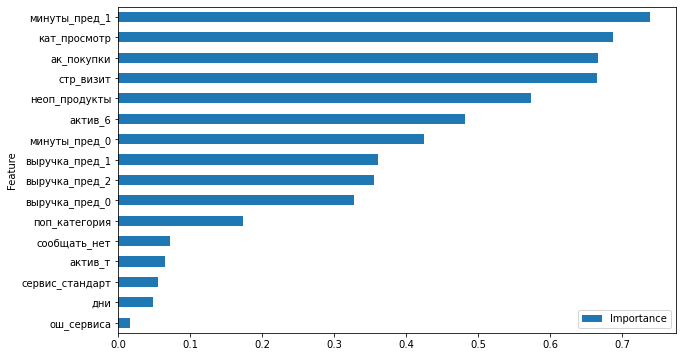

In [90]:
coefficients = clf.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_2.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 
plt.show();

График важности признаков показывает, что наиболее важный признак - минуты_пред_1, кат_просмотр, ак_покупки, стр_визит,  неоп_продукты.

Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, их оценивают методом SHAP (SHapley Additive exPlanations). Для этого он вычисляет, как отельный признак помог присвоить модели итоговое значение целевого признака.

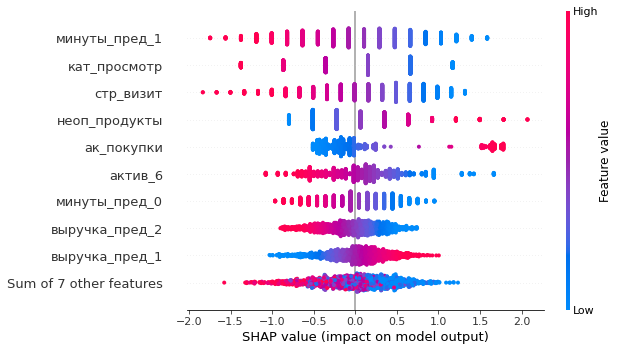

In [91]:
explainer = shap.LinearExplainer(clf, X_2)
shap_values = explainer(X_2)

shap.plots.beeswarm(shap_values) 

Признаки "значение времени, проведенного на сайте за предыдущий месяц", "средний просмотр категорий за визит", "среднее количество просмотренных страниц за визит",  "значение времени, проведенного на сайте за текущий месяц", "среднемесячное значение маркетинговых коммуникаций за 6 месяцев", "выручка за препредпоследний месяц" вносят большой вклад, при этом склоняя модель к 0 (прежний уровень активности) значению целевого признака, а вот признаки "акционные покупки", "выручка за предпоследний месяц" и "количество неоплаченных продуктов в корзине" к значению 1 (активность снизилась).

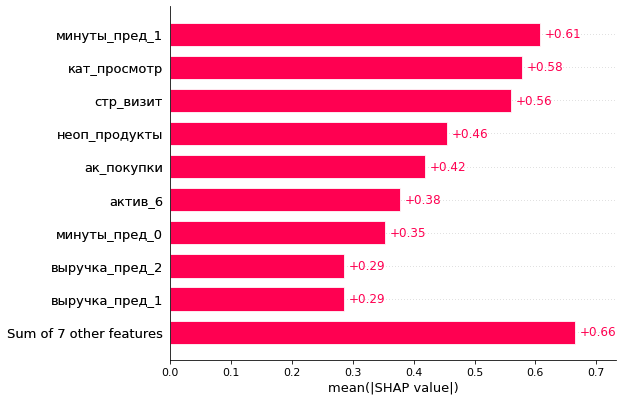

In [92]:
shap.plots.bar(shap_values) 

Признаки "Среднее количество просмотренных страниц за визит", "значение времени, проведенного на сайте за предыдущий месяц", "средний просмотр категорий за визит" сильнее всех влияют на прогнозы модели

## СЕГМЕНТАЦИЯ ПОКУПАТЕЛЕЙ
<a id="part_8"></a> 

* Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.
* Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
        Проведите графическое и аналитическое исследование группы покупателей.
        Сделайте предложения по работе с сегментом для увеличения покупательской активности.
* Сделайте выводы о сегментах:
        какой сегмент вы взяли для дополнительного исследования,
        какие предложения вы сделали и почему.

В качестве изучаемого сегмента возьмем клиентов с максимальной прибылью и высокой вероятностью снижения активности

Как правило, активность снижается после проведения акций, когда клиенты в предпоследний и текущий месяц потратили много денег (графики построены в разделе EDA)

In [93]:
market_all.head(5)

,index,сервис,сообщать,актив_6,актив_т,дни,ак_покупки,поп_категория,кат_просмотр,неоп_продукты,...,стр_визит,выручка_пред_2,выручка_пред_1,выручка_пред_0,минуты_пред_1,минуты_пред_0,y_test,y_test_pred1,id,прибыль
1,809,стандарт,да,4.0,3,432,0.16,Косметика и аксесуары,4,1,...,13,4685.0,5646.5,6609.8,17,22,0,0.014590,215349,4.16
2,148,премиум,да,4.0,4,684,0.40,Техника для красоты и здоровья,1,6,...,4,4896.0,5020.0,5237.1,11,11,1,0.946645,215350,3.13
3,192,премиум,да,1.4,5,355,0.33,Мелкая бытовая техника и электроника,1,1,...,5,4826.0,5277.5,6118.6,9,10,1,0.907173,215351,4.87
4,786,премиум,да,3.3,5,786,0.16,Косметика и аксесуары,4,0,...,11,4590.0,4926.0,5347.2,8,19,0,0.144479,215352,4.21
5,196,стандарт,да,2.4,4,1025,0.40,Кухонная посуда,3,2,...,6,4314.0,4732.5,4954.8,9,12,1,0.833945,215353,3.95


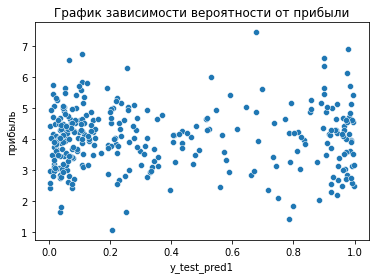

In [94]:
fig, axes = plt.subplots()

sns.scatterplot(x=market_all['y_test_pred1'], y=market_all['прибыль'], ax=axes)
plt.title("График зависимости вероятности от прибыли")
plt.show() 

Порог для прибыльности и вероятности снижения активности от 0,7. Чем выше прибыль от клиента, тем выше вероятность снижения его активности

In [95]:
market_all_1 = market_all.query('прибыль>=4 & y_test_pred1>0.7')
market_all_1

,index,сервис,сообщать,актив_6,актив_т,дни,ак_покупки,поп_категория,кат_просмотр,неоп_продукты,...,стр_визит,выручка_пред_2,выручка_пред_1,выручка_пред_0,минуты_пред_1,минуты_пред_0,y_test,y_test_pred1,id,прибыль
3,192,премиум,да,1.4,5,355,0.33,Мелкая бытовая техника и электроника,1,1,...,5,4826.0,5277.5,6118.6,9,10,1,0.907173,215351,4.87
12,120,стандарт,да,2.7,4,515,0.94,Косметика и аксесуары,1,4,...,2,4698.0,6060.0,6346.0,9,11,1,0.995528,215360,4.55
27,1287,стандарт,да,0.9,3,932,0.35,Косметика и аксесуары,3,3,...,5,4980.0,4452.0,5039.6,12,18,0,0.784584,215375,4.18
40,560,премиум,нет,4.0,4,845,0.12,Домашний текстиль,2,7,...,5,4933.0,4396.0,4991.4,10,12,1,0.890453,215388,5.16
42,105,премиум,да,2.4,3,506,0.22,Товары для детей,1,5,...,3,4290.0,3332.0,3143.5,9,12,1,0.984187,215390,5.70
58,248,стандарт,да,1.5,4,684,0.90,Косметика и аксесуары,3,0,...,4,4824.0,4917.0,5175.7,14,8,1,0.927514,215406,5.00
65,319,премиум,да,3.0,4,467,0.95,Косметика и аксесуары,2,6,...,3,4544.0,5159.0,5424.2,8,8,1,0.996340,215413,5.40
68,1213,стандарт,да,4.0,4,842,0.28,Техника для красоты и здоровья,2,8,...,10,4430.0,4238.0,4534.4,16,7,0,0.813690,215416,4.22
83,377,стандарт,да,2.4,5,846,0.40,Товары для детей,2,4,...,5,4908.0,4995.0,5385.0,10,14,1,0.939423,215431,4.28
91,1085,стандарт,нет,4.0,3,788,0.23,Товары для детей,2,3,...,7,4884.0,4752.0,4996.4,9,5,0,0.899796,215439,6.33


In [96]:
market_10 = market_all_1.pivot_table(index = ['поп_категория'], values =['прибыль', 'y_test_pred1', 'ак_покупки'], aggfunc = ['mean', 'median'])
market_10

mean                       \
                                     y_test_pred1 ак_покупки   прибыль   
поп_категория                                                            
Домашний текстиль                        0.946602   0.371429  4.820000   
Косметика и аксесуары                    0.924185   0.518000  4.691333   
Кухонная посуда                          0.895528   0.462500  5.090000   
Мелкая бытовая техника и электроника     0.911395   0.275000  4.520000   
Техника для красоты и здоровья           0.854814   0.306667  4.510000   
Товары для детей                         0.919252   0.597333  4.924667   

                                           median                     
                                     y_test_pred1 ак_покупки прибыль  
поп_категория                                                         
Домашний текстиль                        0.962856      0.300   4.680  
Косметика и аксесуары                    0.940869      0.390   4.620  
Кухонная посуда                          0.878054      0.310   5.055  
Мелкая бытовая техника и электроника     0.911395      0.275   4.520  
Техника для красоты и здоровья           0.813690      0.320   4.220  
Товары для детей                         0.939423      0.400   4.640

Категория "косметика и аксесуары" имеет пороговое значение вероятности, при этом доля акционных покупок здесь одна из самых высоких (а данный признак прямо влияет на снижение активности), при этом прибыль в данной категории самая высокая, скорее всего активность снизится у покупателей в данной категории (поэтому, здесь для удержания покупателей, возможно нужно провести какую_нибудь акцию для удержания(возможно ввести рекомендательную систему, что вам могло бы еще пригодиться к уже купленному товару (например, к косметике порекомендовать средство для ее удаления и т.д.). Категория "Товары для детей" также имеет высокие медианную вероятность снижения активности, долю акционных покупок и прибыль, что также может повлечь в скором времени уменьшение активности (покупателей данной категории можно привлечь системой накопления баллов на следующую покупку). В категории "Домашний текстиль" вероятность снижения активности высокая, при этом доля акционных покупок одна из самых низких (для данной категории можно провести больше акций или предложений). 

Скорее всего, заинтересованность клиентов повысится, когда они снова почувствуют необходимость в этих товарах и накопят денег. Но все же для поддержания интереса к сервису, клиентам нужно напоминать о себе, возможно повышением лояльности к клиентам, сезонными акциями, акциями на дополнительные услуги (например, скидка на доставку товара), или же улучшать рекомендательную систему сопутствующих товаров, повышать удобство сервиса.

## ОБЩИЙ ВЫВОД
<a id="part_9"></a> 

ЦЕЛЬ ПРОЕКТА:
* разработка модели, которая предскажет вероятность снижения покупательской активности.
* выделение сегмента покупателей, формулирование предложений по увеличению его покупательской активности. 

ШАГ 1.ЗАГРУЗКА ДАННЫХ. 
* Датафрейм marketf содержит 1300 ненулевых строк и 13 столбцов. Типы данных соответствуют содержимому. Наименования столбцов были переименованы для удобства. 
* Датафрейм marketm содержит 3900 ненулевых строк и 3 столбца. Типы данных соответствуют содержимому. Наименования столбцов были переименованы для удобства. 
* Датафрейм markett содержит 2600 ненулевых строк и 3 столбца. Типы данных соответствуют содержимому. Наименования столбцов были переименованы для удобства. 
* Датафрейм money содержит 1300 ненулевых строк и 2 столбца. Типы данных в столбце "прибыль" не соответствуют содержимому. Отделим целую часть числа от дробной вместо запятой - точкой и изменим тип данных на float. Наименования столбцов были переименованы для удобства.

ШАГ 2.ПРЕДОБРАБОТКА ДАННЫХ.
* В столбце "сервис" указано три тарифа, но как видно, один из них имеет ошибку в написании, исправили это. Проверка количества уникальных значений и количества дубликатов, показала, что пропущенных значений в данных нет, дубликатов также нет. На первый взгляд, данные готовы к дальнейшему исследованию.

ШАГ 3. ОБЪЕДИНЕНИЕ ТАБЛИЦ
* Объединили таблицы market_file.csv, market_money.csv, market_time.csv, money.csv. Данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделали отдельный столбец для каждого периода.

ШАГ 4. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ (EDA)
* Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага. Клиентов, которые ничего не покупали в течение последних трех месяцев, нет. Есть клиенты, которые делали покупки только в текущем месяце, а вот в предыдущие два - не делали
* Рассчитали числовые характеристики для непрерывных случайных величин. Числовые характеристики показывают, что среднее и медиана имеют сравнимые значения, то есть почти одинаковые, следовательно, можно предположить, что большого количества выбросов в данных нет. Для более детального рассмотрения построим диаграммы "ящик с усами". По даным диаграмм можно наблюдать выбросы по признакам: актив6, ак_покупки, неоп_продукты, выручка. Удалять их не будем, возможно, такие значения могут встречаться.
* Построим гистограммы и выполнили проверку гипотезы о нормальности распределения признаков. Построим гистограммы распределения категориальных признаков. На графиках видно, что что активность снизилась у 550 человек, примиум сервис используют 400, а стандарт 900 человек, 400 человек не дают разрешение на сообщения, а 900 дают, товары для детей пользуются большим интересом, чем товары других категорий.
* Уровень активности снижается у клиентов, которые просматривают от 0 до 6 страниц за визит ('стр_визит') Уровень активности снижается, если клиент проводит на сайте за предыдущий месяц от 5 до 11 минут ('минуты_пред_1') Уровень активности снижается, если клиент в среднем просматривал за визит в течение последнего месяца 1-2 категории ('кат_просмотр') Активность снижается, если среднемесячная доля покупок по акции достигает от 0.3 до 1 ('ак_покупки') Активность снижается, если число неоплаченных продуктов в корзине от 4 и выше ('неоп_продукты') Уровень активности ниже среднего уровня активности в целом по группам товаров: товары для детей (0.56), домашний текстиль (0.6), косметика и аксессуары (0.53), техника для красоты и здоровья (0.52)

ШАГ 5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ

Провели корреляционный анализ признаков. По матрице видно, согласно шкале Чеддока, что: имеется высокая взаимосвязь между:
* "выручка_пред_1" и "выручка_пред_2" (0.73)
* "выручка_пред_2" и "ак_покупки" (0.75)

     заметная взаимосвязь:
* "выручка_пред_1" и "ак_покупки" (0.64)
* "минуты_пред_1" и "активность" (0.68)
* "минуты_пред_0" и "активность" (0.58)   

Исследовали мультиколлинеарность с помощью коэффициента инфляции дисперсии (VIF) , который измеряет корреляцию и силу корреляции между независимыми переменными. В нашем случае все коэффициенты находятся в пределах от 1 до 5, что говорит об умеренной корреляции, а следовательно можно полагать, что даже в случае присутствия некоторой мультиколлинеарности, модель покажет правдивые результаты.

ШАГ 6. СОЗДАНИЕ ПАЙПЛАЙНА

Во время подготовки данных использован ColumnTransformer. Количественные и категориальные признаки обработаны в пайплайне раздельно. Для кодирования категориальных признаков использованы согласно заданию два кодировщика, для масштабирования количественных — два скейлера.
Обучены четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них подбран  один гиперпараметр. 
Выбрана лучшая модель: 
* 'ohe', OneHotEncoder
* 'ord', OrdinalEncoder
* 'num', StandardScaler()
* LogisticRegression(C=5, penalty='l1', random_state=50, solver='liblinear')
Метрика лучшей модели на тренировочной выборке: 0.897466656739384; Метрика ROC-AUC на тестовой выборке: 0.8532137698603756; 
acc (отношение верных ответов к общему количеству ответов) =  0.87; recall (полнота, смогла ли модель классификации присвоить класс 1 всем объектам этого класса) =  0.77; precisions (точность, с которой модель присваивает объектам класс 1) =  0.89; 
Коэффициент Мэттьюса: 0.730; F1-мера: 0.823; Каппа Коэна: 0.725.

ШАГ 7. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, их оценивают методом SHAP (SHapley Additive exPlanations). Для этого он вычисляет, как отельный признак помог присвоить модели итоговое значение целевого признака. Признаки "Среднее количество просмотренных страниц за визит", "значение времени, проведенного на сайте за предыдущий месяц", "средний просмотр категорий за визит", "значение времени, проведенного на сайте за текущий месяц", "среднемесячное значение маркетинговых коммуникаций за 6 месяцев", "популярная категория", "выручка за препредпоследний месяц" вносят большой вклад, при этом склоняя модель к 0 значению целевого признака, а вот признаки "акционные покупки" и "количество неоплаченных продуктов в корзине" к значению 1.

ШАГ 8. СЕГМЕНТАЦИЯ ПОКУПАТЕЛЕЙ

В качестве изучаемого сегмента возьмем клиентов с максимальной прибылью и высокой вероятностью снижения активности.  Как правило, активность снижается после проведения акций, когда клиенты в предпоследний и текущий месяц потратили много денег (графики построены в разделе EDA). Порог для прибыльности и вероятности снижения активности около 0,7. Чем выше прибыль от клиента, тем выше вероятность снижения его активности. Категория "косметика и аксесуары" имеет пороговое значение вероятности, при этом доля акционных покупок здесь одна из самых высоких (а данный признак прямо влияет на снижение активности), при этом прибыль в данной категории самая высокая, скорее всего активность снизится у покупателей в данной категории (поэтому, здесь для удержания покупателей, возможно нужно провести какую_нибудь акцию для удержания(возможно ввести рекомендательную систему, что вам могло бы еще пригодиться к уже купленному товару (например, к косметике порекомендовать средство для ее удаления и т.д.). Категория "Товары для детей" также имеет высокие медианную вероятность снижения активности, долю акционных покупок и прибыль, что также может повлечь в скором времени уменьшение активности (покупателей данной категории можно привлечь системой накопления баллов на следующую покупку). В категории "Домашний текстиль" вероятность снижения активности высокая, при этом доля акционных покупок одна из самых низких (для данной категории можно провести больше акций или предложений). Скорее всего, заинтересованность клиентов повысится, когда они снова почувствуют необходимость в этих товарах и накопят денег. Но все же для поддержания интереса к сервису, клиентам нужно напоминать о себе, возможно повышением лояльности к клиентам, сезонными акциями, акциями на дополнительные услуги (например, скидка на доставку товара), или же улучшать рекомендательную систему сопутствующих товаров, повышать удобство сервиса.